In [23]:
# importing the libraries required
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import os 
from sklearn.model_selection import train_test_split # splitting of the data

from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report # evaluation
import warnings
warnings.filterwarnings('ignore')


## Loading the data

In [2]:
def load_data():
    possible_paths = [
        "./data/hypertension_dataset.csv",
        "../data/hypertension_dataset.csv",
        "data/hypertension_dataset.csv",
        "hypertension_dataset.csv",       
    ]  

    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            break
    else:
        raise FileNotFoundError(
            "Could not find hypertension_dataset.csv. "
            "Make sure the dataset is in 'data/' (or provide a sample)."
        )
    return df

In [3]:
df = load_data()

In [4]:
df.head()

,Country,Age,BMI,Cholesterol,Systolic_BP,Diastolic_BP,Smoking_Status,Alcohol_Intake,Physical_Activity_Level,Family_History,...,Sleep_Duration,Heart_Rate,LDL,HDL,Triglycerides,Glucose,Gender,Education_Level,Employment_Status,Hypertension
0,UK,58,29.5,230,160,79,Never,27.9,Low,Yes,...,6.1,80,100,75,72,179,Female,Primary,Unemployed,High
1,Spain,34,36.2,201,120,84,Never,27.5,High,Yes,...,9.8,56,77,47,90,113,Male,Secondary,Unemployed,High
2,Indonesia,73,18.2,173,156,60,Current,1.8,High,Yes,...,5.2,75,162,56,81,101,Male,Primary,Employed,Low
3,Canada,60,20.3,183,122,94,Never,11.6,Moderate,Yes,...,7.5,71,164,93,94,199,Female,Secondary,Retired,High
4,France,73,21.8,296,91,97,Never,29.1,Moderate,Yes,...,5.0,52,108,74,226,157,Female,Primary,Employed,High


## Cleaning the data

We will drop unnecessary columns and focus on features of high importance such as Age, BMI (Weight/(Height)^2), Heart_Rate, Systolic_BP, Diastolic_BP, and Hypertension.

In [5]:
df.columns

Index(['Country', 'Age', 'BMI', 'Cholesterol', 'Systolic_BP', 'Diastolic_BP',
       'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity_Level',
       'Family_History', 'Diabetes', 'Stress_Level', 'Salt_Intake',
       'Sleep_Duration', 'Heart_Rate', 'LDL', 'HDL', 'Triglycerides',
       'Glucose', 'Gender', 'Education_Level', 'Employment_Status',
       'Hypertension'],
      dtype='object')

In [6]:
df.drop(columns=['Cholesterol',
       'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity_Level',
       'Family_History', 'Diabetes', 'Stress_Level', 'Salt_Intake',
       'Sleep_Duration', 'LDL', 'HDL', 'Triglycerides',
       'Glucose', 'Education_Level', 'Employment_Status'], inplace=True)

In [7]:
df["Country"].unique()

array(['UK', 'Spain', 'Indonesia', 'Canada', 'France', 'South Korea',
       'Brazil', 'China', 'India', 'Italy', 'Germany', 'USA', 'Argentina',
       'Australia', 'Saudi Arabia', 'Russia', 'Japan', 'Turkey', 'Mexico',
       'South Africa'], dtype=object)

We will use the data from South Africa since its living conditions are similart to that of Kenya in the following ways:

1. Middle-income African country
2. High urban–rural divide like Kenya
3. Rising obesity and hypertension prevalence
4. Similar healthcare access inequalities
5. Comparable salt intake and lifestyle transitions 
6. Large populations living at moderate-to-high altitude

Blood pressure is not determined solely by individual physiology but is also influenced by geographical and environmental factors associated with where a person lives.

In [8]:
df = df[df['Country'] == 'South Africa']

In [9]:
df.shape

(8835, 8)

In [10]:
df.drop_duplicates()

,Country,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate,Gender,Hypertension
68,South Africa,83,16.6,156,63,91,Male,High
71,South Africa,37,38.7,102,85,51,Male,High
74,South Africa,73,26.4,92,102,50,Male,High
118,South Africa,65,17.3,100,84,75,Female,High
126,South Africa,85,25.7,177,64,93,Female,High
...,...,...,...,...,...,...,...,...
174836,South Africa,39,21.5,120,60,52,Male,High
174910,South Africa,49,27.8,122,72,93,Female,High
174928,South Africa,31,22.1,178,104,63,Female,High
174941,South Africa,40,21.3,160,87,61,Male,Low


In [11]:
# dropping the index without keeping the old one 
df = df.reset_index(drop=True)

In [12]:
# Dropping Country Column 
df.drop(columns=['Country'], inplace=True)

## Final Dataset

In [13]:
df.head()

,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate,Gender,Hypertension
0,83,16.6,156,63,91,Male,High
1,37,38.7,102,85,51,Male,High
2,73,26.4,92,102,50,Male,High
3,65,17.3,100,84,75,Female,High
4,85,25.7,177,64,93,Female,High


In [14]:
df.shape

(8835, 7)

# Exploring the Data

In [15]:
df.describe()

,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate
count,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000
mean,53.645388,27.542852,134.929145,89.380985,74.361969
std,20.865824,7.204658,26.112129,17.298946,14.463394
min,18.000000,15.000000,90.000000,60.000000,50.000000
25%,35.000000,21.300000,113.000000,74.000000,62.000000
50%,54.000000,27.500000,135.000000,90.000000,74.000000
75%,72.000000,33.700000,158.000000,104.000000,87.000000
max,89.000000,40.000000,179.000000,119.000000,99.000000


Ages are 18 - 89 so we are dealling with adults primarily

In [16]:
hyp = df.groupby(df['Hypertension'])['Age'].count()
hyp

Hypertension
High    6368
Low     2467
Name: Age, dtype: int64

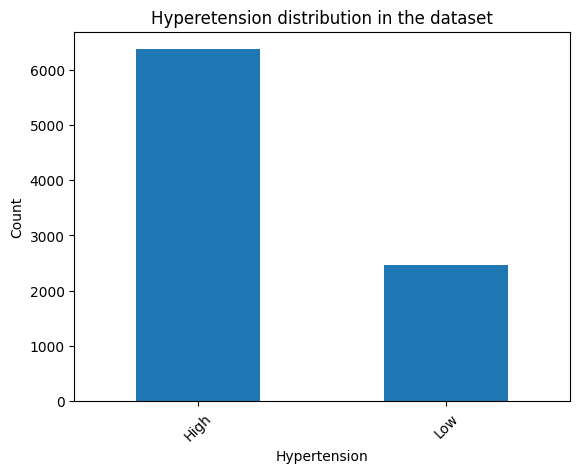

In [17]:
hyp.plot(
    kind = "bar",
    xlabel = "Hypertension",
    ylabel = "Count",
    title = "Hyperetension distribution in the dataset"
)
plt.xticks(rotation=45);

We can see we are dealing with a highly imbalanced dataset when it comes Hypertension.
There is large amount of people with High hypertension

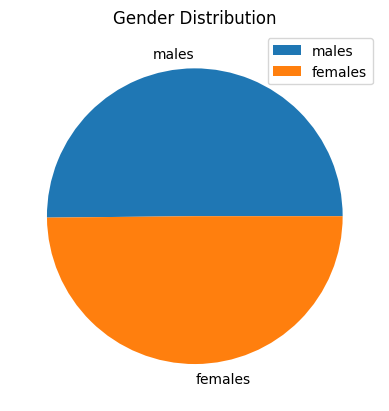

In [18]:
males = (df["Gender"] == 'Male').sum().astype(float)
females = (df["Gender"] == 'Female').sum().astype(float)

gender = np.array([males, females])
plt.pie(gender, labels = ['males','females'])
plt.title("Gender Distribution")
plt.legend()
plt.show()

In [19]:
print(f"males : {round(males/(males + females) * 100, 2)}% \nfemales : {round(females/(males + females) * 100, 2)}%")

males : 50.15% 
females : 49.85%


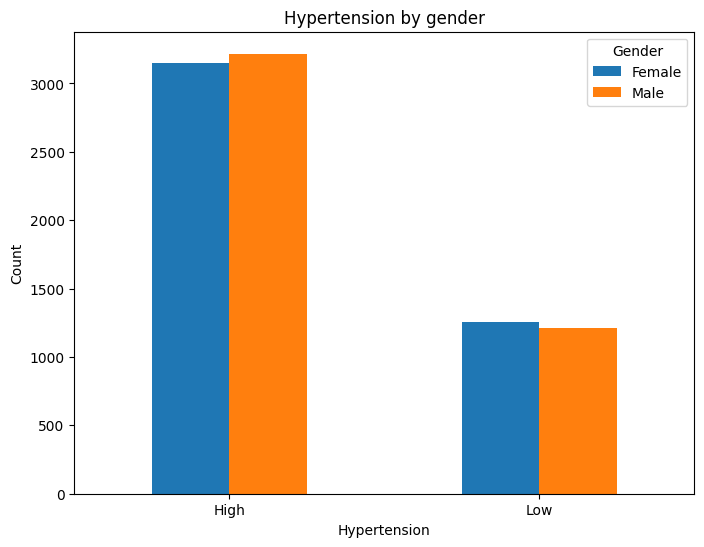

In [20]:
# Hypertension by Gender
grouped = df.groupby(['Hypertension','Gender'])['Age'].count().unstack()
grouped.plot(kind='bar', figsize=(8, 6))
plt.title('Hypertension by gender')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=0)

plt.show()



In [24]:
## Correlation between numeric variables 
corr = df.select_dtypes("number").corr()
corr

,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate
Age,1.000000,0.009314,-0.016896,0.015341,0.005318
BMI,0.009314,1.000000,0.000530,-0.013826,-0.007221
Systolic_BP,-0.016896,0.000530,1.000000,-0.014361,0.004068
Diastolic_BP,0.015341,-0.013826,-0.014361,1.000000,0.003227
Heart_Rate,0.005318,-0.007221,0.004068,0.003227,1.000000


<Axes: >

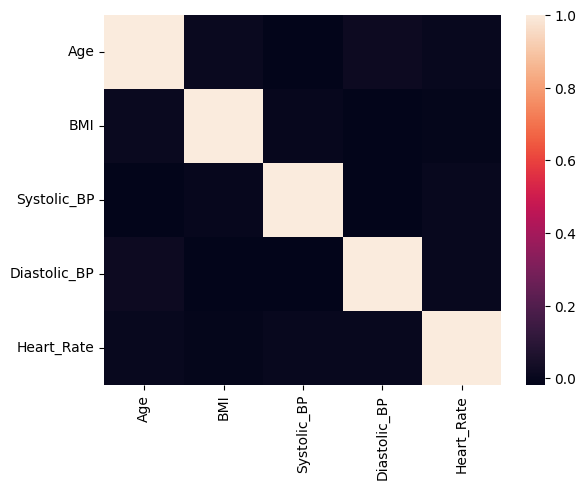

In [25]:
sns.heatmap(corr)

In [26]:
# saving the cleaned data
df.to_csv('../data/hypertension_cleaned.csv', index=False)

We can see the data is not highly correlated.

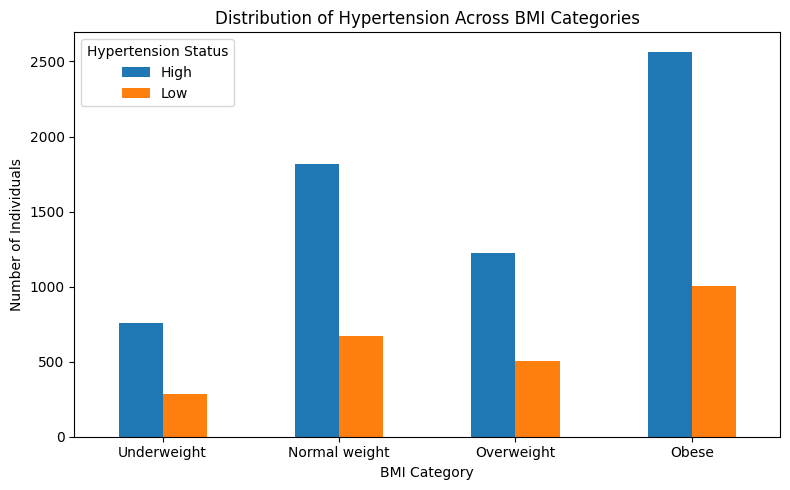

In [27]:
# Define BMI categories
under_weight = df[df['BMI'] <= 18]
normal_weight = df[(df['BMI'] > 18) & (df['BMI'] <= 24.9)]
over_weight = df[(df['BMI'] > 24.9) & (df['BMI'] <= 29.9)]
obese = df[df['BMI'] > 29.9]

# hypertension counts
uw_counts = under_weight['Hypertension'].value_counts()
nw_counts = normal_weight['Hypertension'].value_counts()
ow_counts = over_weight['Hypertension'].value_counts()
ob_counts = obese['Hypertension'].value_counts()

# combine to one dataframe
hypertension_bmi = pd.DataFrame({
    'Underweight': uw_counts,
    'Normal weight': nw_counts,
    'Overweight': ow_counts,
    'Obese': ob_counts
}).fillna(0)

hypertension_bmi.T.plot(kind='bar', figsize=(8, 5))

plt.title('Distribution of Hypertension Across BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=0)
plt.legend(title='Hypertension Status')
plt.tight_layout()
plt.show()


We can see that Obese people have the highest number of people with high hypertension.

# Splitting the data

In [28]:
# Mapping the gender to 1 and 0
df['Gender'].replace({'Male':1, 'Female':0}, inplace=True)

In [29]:
# Mapping hypertension to 1 and 0 
df['Hypertension'].replace({'High':1, 'Low':0}, inplace=True)

In [30]:
df.head()

,Age,BMI,Systolic_BP,Diastolic_BP,Heart_Rate,Gender,Hypertension
0,83,16.6,156,63,91,1,1
1,37,38.7,102,85,51,1,1
2,73,26.4,92,102,50,1,1
3,65,17.3,100,84,75,0,1
4,85,25.7,177,64,93,0,1


In [31]:
# Splitting the Data into Features and the Targets

X = df.drop('Hypertension',axis='columns') # features
y = df['Hypertension'] # targets

In [32]:
print(f"features: {X.shape}, target: {y.shape}")

features: (8835, 6), target: (8835,)


In [33]:
# Splitting the data into Test and Training datasets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
y_train.value_counts()

Hypertension
1    5083
0    1985
Name: count, dtype: int64

In [35]:
y.value_counts()

Hypertension
1    6368
0    2467
Name: count, dtype: int64

In [36]:
y_test.value_counts()

Hypertension
1    1285
0     482
Name: count, dtype: int64

## Building the Model 

### Random Forest Model

In [37]:
# Defining the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model
rf_classifier.fit(X_train, y_train)

# Prediction
y_pred = rf_classifier.predict(X_test)

# Evaluation of the model
classification_rep = classification_report(y_test, y_pred)

In [39]:
print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.02      0.04       482
           1       0.72      0.96      0.83      1285

    accuracy                           0.71      1767
   macro avg       0.46      0.49      0.44      1767
weighted avg       0.58      0.71      0.61      1767



## References

Bisong, E., Jibril, N., Premnath, P., Buligwa, E., Oboh, G., & Chukwuma, A. (2024). Predicting high blood pressure using machine learning models in low- and middle-income countries. BMC Medical Informatics and Decision Making, 24, 234. https://doi.org/10.1186/s12911-024-02634-9

### XGBoost

In [40]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'
